In [106]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
%autoreload 2

import hydra
import sys
import torch

import os
import hydra
import torch
import matplotlib.pyplot as plt
import wandb
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tqdm.auto import tqdm

from RegularizingEmbeddings.amplification import *
from RegularizingEmbeddings.data.data_generation import embed_signal_torch
from RegularizingEmbeddings.lightning.train import make_trajectories, postprocess_data, generate_train_and_test_sets

In [108]:
# load the config
with hydra.initialize(version_base="1.3", config_path="../conf"):
    config = hydra.compose(config_name="config")


In [109]:
# Initialize data module
torch.random.manual_seed(config.data.flow.random_state)
eq, sol, dt = make_trajectories(config)
values = postprocess_data(config, sol)

config.model.input_dim = values.shape[-1]

# Create train and test sets
train_dataset, val_dataset, test_dataset, trajs = generate_train_and_test_sets(values, **config.data.train_test_params)

Sequence Indices: 100%|██████████| 1175/1175 [00:00<00:00, 469317.89it/s]

Train dataset shape: torch.Size([16450, 25, 1])
Validation dataset shape: torch.Size([4700, 25, 1])
Test dataset shape: torch.Size([2350, 25, 1])
Train trajectories dataset shape: torch.Size([14, 1200, 1])
Validation trajectories dataset shape: torch.Size([4, 1200, 1])
Test trajectories dataset shape: torch.Size([2, 1200, 1])


In [144]:
obs_noise_scale = trajs['train_trajs'].sequence.std()*(1e-1)
values_torch = torch.from_numpy(values).float() + torch.randn_like(torch.from_numpy(values).float())*obs_noise_scale

In [145]:
n_neighbors = 10
max_T = 8

values_dict = {}
n_delays_vals = range(1, 50)
delay_interval_vals = range(1, 10,2)
iterator = tqdm(total=len(n_delays_vals) * len(delay_interval_vals))
for n_delays in n_delays_vals:
    values_dict[n_delays] = {}
    for delay_interval in delay_interval_vals:
        # drop the first (n_delays - 1) * delay_interval points
        data = values_torch[..., (n_delays - 1) * delay_interval:, :]
        embedding = embed_signal_torch(values_torch, n_delays=n_delays, delay_interval=delay_interval)
        sig, E_k, eps_k = compute_noise_amp_k(
            data, embedding, n_neighbors, max_T, normalize=True
        )
        values_dict[n_delays][delay_interval] = {'sig': sig, 'E_k': E_k, 'eps_k': eps_k}
        iterator.update(1)
iterator.close()

  0%|          | 0/245 [00:00<?, ?it/s]

100%|██████████| 245/245 [01:33<00:00,  2.63it/s]


 41%|████      | 180/441 [06:38<09:38,  2.22s/it]


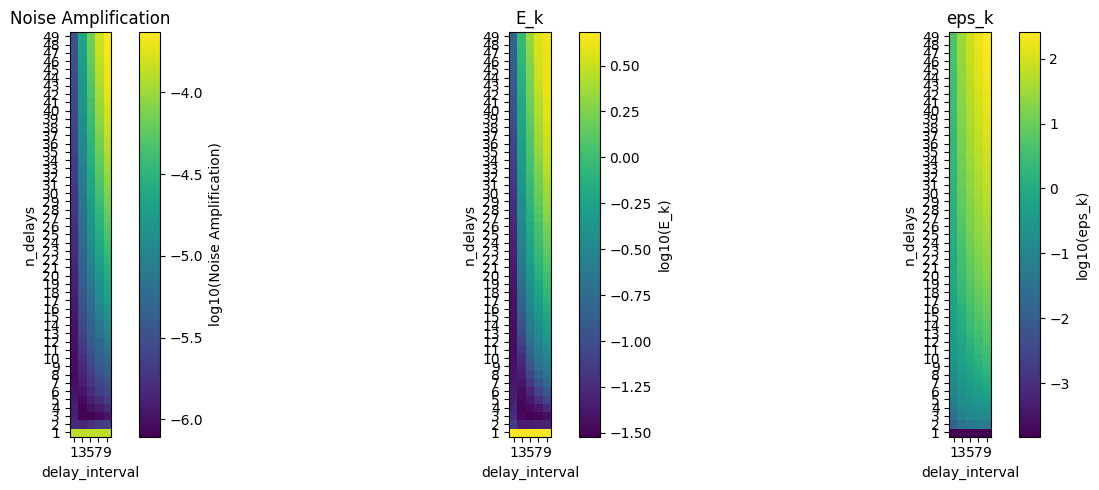

In [137]:
# Convert nested dictionary to 2D arrays for plotting
sigs_array = np.zeros((len(n_delays_vals), len(delay_interval_vals)))
E_k_array = np.zeros((len(n_delays_vals), len(delay_interval_vals)))
eps_k_array = np.zeros((len(n_delays_vals), len(delay_interval_vals)))

for i, n_delays in enumerate(n_delays_vals):
    for j, delay_interval in enumerate(delay_interval_vals):
        sigs_array[i,j] = values_dict[n_delays][delay_interval]['sig']
        E_k_array[i,j] = values_dict[n_delays][delay_interval]['E_k']
        eps_k_array[i,j] = values_dict[n_delays][delay_interval]['eps_k']

# Create figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot sigs
im1 = ax1.imshow(np.log10(sigs_array), origin='lower')
plt.colorbar(im1, ax=ax1, label='log10(Noise Amplification)')
ax1.set_xticks(range(len(delay_interval_vals)))
ax1.set_yticks(range(len(n_delays_vals)))
ax1.set_xticklabels(delay_interval_vals)
ax1.set_yticklabels(n_delays_vals)
ax1.set_xlabel("delay_interval")
ax1.set_ylabel("n_delays")
ax1.set_title("Noise Amplification")

# Plot E_k
im2 = ax2.imshow(np.log10(E_k_array), origin='lower')
plt.colorbar(im2, ax=ax2, label='log10(E_k)')
ax2.set_xticks(range(len(delay_interval_vals)))
ax2.set_yticks(range(len(n_delays_vals)))
ax2.set_xticklabels(delay_interval_vals)
ax2.set_yticklabels(n_delays_vals)
ax2.set_xlabel("delay_interval")
ax2.set_ylabel("n_delays")
ax2.set_title("E_k")

# Plot eps_k
im3 = ax3.imshow(np.log10(eps_k_array), origin='lower')
plt.colorbar(im3, ax=ax3, label='log10(eps_k)')
ax3.set_xticks(range(len(delay_interval_vals)))
ax3.set_yticks(range(len(n_delays_vals)))
ax3.set_xticklabels(delay_interval_vals)
ax3.set_yticklabels(n_delays_vals)
ax3.set_xlabel("delay_interval")
ax3.set_ylabel("n_delays")
ax3.set_title("eps_k")

plt.tight_layout()
plt.show()


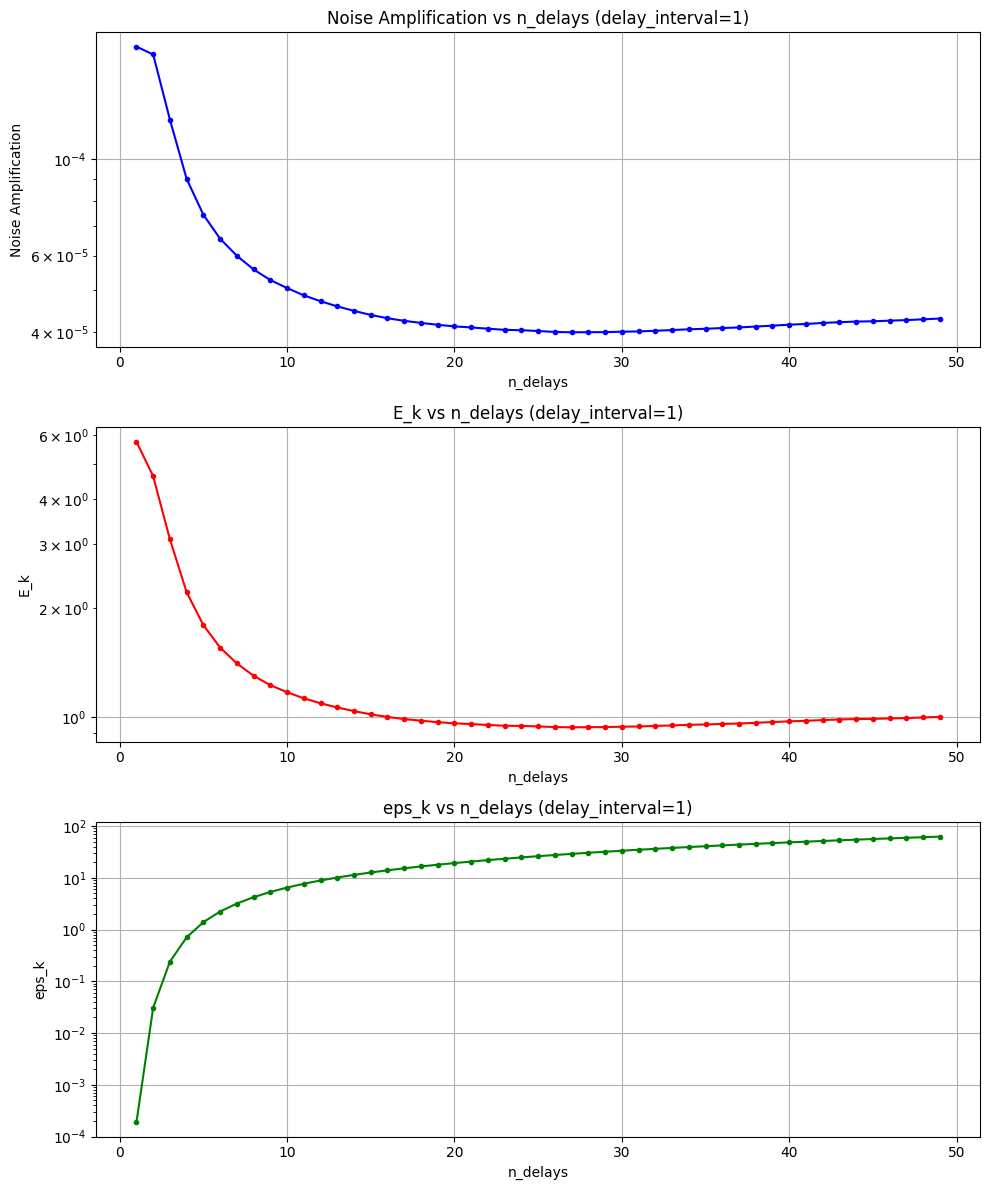

In [147]:
# Extract values for delay_interval=9
delay_interval = 1
sigs_line = []
E_k_line = []
eps_k_line = []

for n_delays in n_delays_vals:
    sigs_line.append(values_dict[n_delays][delay_interval]['sig'])
    E_k_line.append(values_dict[n_delays][delay_interval]['E_k']) 
    eps_k_line.append(values_dict[n_delays][delay_interval]['eps_k'])

# Create figure with three subplots vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot sigs
ax1.plot(n_delays_vals, sigs_line, 'b.-')
ax1.set_xlabel("n_delays")
ax1.set_ylabel("Noise Amplification")
ax1.set_yscale('log')
ax1.grid(True)
ax1.set_title(f"Noise Amplification vs n_delays (delay_interval={delay_interval})")

# Plot E_k
ax2.plot(n_delays_vals, E_k_line, 'r.-')
ax2.set_xlabel("n_delays")
ax2.set_ylabel("E_k")
ax2.set_yscale('log')
ax2.grid(True)
ax2.set_title(f"E_k vs n_delays (delay_interval={delay_interval})")

# Plot eps_k
ax3.plot(n_delays_vals, eps_k_line, 'g.-')
ax3.set_xlabel("n_delays")
ax3.set_ylabel("eps_k")
ax3.set_yscale('log')
ax3.grid(True)
ax3.set_title(f"eps_k vs n_delays (delay_interval={delay_interval})")

plt.tight_layout()
plt.show()
